# Executive Summary

Project Goal: to build a model that could predict Single Unit Property Values

    Conditions: Utilize data only from the May-August 2017 period
    
    Challenges: 
    
        * Defining Single Unit Property and relevant useid codes
        
        * Untidy Data: Null Values, Duplicates, Outliers 
        
        * Identify County specific data using FIPS codes
        
            * Calculate Tax Rate by County
            
        * Cross correlations in data
    
Project Findings: 

    * As suspected, square feet was a primary driver but other suspected features such as useid (type of Single Unit Propery) and age of home were not
    
    * The predictive value of the models employed declined as Single Unit Property values grew and RMSEs widened
    
        * However, did offer predictive value overall beating benchmarkes.  Model predictive value high sub $250k value
        
    * It would be easy to write this phenomena off to outliers but the distribution of the data was normal with long but consistent tail bservations. 

Conclusion: The Polynomial Regressor algorithm offered the most predictive value

    * Tortoise vs Hare: steadily outperformed as Single Unit Property Values increased vs other models
    
    * The Polynomial Regressor was able to capture information further out on the distribution curve than the other models.  My assumption is that there are other features that need to be explored that weren't in this project
    
        * My suspicions are corroborated by the heavy correlations between square feet and baths/beds in thd data set explored.  
        
        * Additionally, during the data exploration stage, I observed some relationship between the age of the Units and taxes with seemed anomolous and counter-intuitive
        
Next Steps:  My suspsicions are that location may have strong predictive value and would be worth exploring

    * I started to see this as I got towards the end of the project and started incorporating County specific information into the information
    
    * It reinforced some of the questions about the relationship between older age and higher taxes found during data exploration
    
    * I believe it would be worth exploring whether Single Unit Property Values are also largely driven by location which would explain an interest in older more established or historic neighborhoods.

    

        

***
Single Unit Properties: A housing unit is a single unit within a larger structure that can be used by an individual or household to eat, sleep, and live. The unit can be in any type of residence, such as a house, apartment, or mobile home, and may also be a single unit in a group of rooms.

The following living quarters are generally not considered housing units and are not included in Census Bureau data:

Dormitories, bunkhouses, barracks
Transient hotels and motels—except for those people who consider it their place of residence
Quarters in institutions, general hospitals, and military installations—there are exceptions including units that are occupied by staff members or resident employees

Note: Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.For purposes of this exercise, exceptions to general rule will not be investigate
***

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

#acquire
import acquire
import explore
import prepare
from env import host, username, password
from pydataset import data

# Acquire

#### Define Single Unit Propertyingle Unit Properties

***
A housing unit is a single unit within a larger structure that can be used by an individual or household to eat, sleep, and live. The unit can be in any type of residence, such as a house, apartment, or mobile home, and may also be a single unit in a group of rooms.

The following living quarters are generally not considered housing units and are not included in Census Bureau data:

* Dormitories, bunkhouses, barracks
* Transient hotels and motels—except for those people who consider it their place of residence
* Quarters in institutions, general hospitals, and military
***

Identify Qualifying PropertyLandUseDesc codes in Zillow data:
* 261 Single Family Residential, 262	Rural Residence, 263	Mobile Home, 264	Townhouse, 265	Cluster Home, 266	Condominium, 267	Cooperative, 268	Row House, 273	Bungalow, 274	Zero Lot Line, 275	Manufactured, Modular, Prefabricated Homes, 276	Patio Home, 279	Inferred Single Family Residential [261-268, 273-279]


In [3]:
# Establish Sequel Ace Connection
#acquire.get_connection('zillow', username=username, host=host, password=password)

In [4]:
# Import data
df = acquire.zillow_data()

In [5]:
df.shape

(28405, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28405 entries, 0 to 28404
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28405 non-null  int64  
 1   bathroomcnt                   28405 non-null  float64
 2   bedroomcnt                    28405 non-null  float64
 3   calculatedfinishedsquarefeet  28347 non-null  float64
 4   fips                          28405 non-null  float64
 5   yearbuilt                     28324 non-null  float64
 6   taxvaluedollarcnt             28404 non-null  float64
 7   taxamount                     28404 non-null  float64
 8   propertylandusetypeid         28405 non-null  float64
 9   transactiondate               28405 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.2+ MB


In [7]:
# Cache original zillow_data df into csv
acquire.cache_zillow_data(cached=False)

In [8]:
# Check for nulls
df.isnull().any()

parcelid                        False
bathroomcnt                     False
bedroomcnt                      False
calculatedfinishedsquarefeet     True
fips                            False
yearbuilt                        True
taxvaluedollarcnt                True
taxamount                        True
propertylandusetypeid           False
transactiondate                 False
dtype: bool

In [9]:
# Check for duplicates using parcelid 
df[df.duplicated(subset=('parcelid'))].count()

parcelid                        23
bathroomcnt                     23
bedroomcnt                      23
calculatedfinishedsquarefeet    23
fips                            23
yearbuilt                       23
taxvaluedollarcnt               23
taxamount                       23
propertylandusetypeid           23
transactiondate                 23
dtype: int64

In [10]:
# Check some of the duplicated parcelids
df[df['parcelid']==10956664]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt,taxamount,propertylandusetypeid,transactiondate
15929,10956664,1.0,2.0,1178.0,6037.0,1943.0,72522.0,824.09,261.0,2017-07-06
15930,10956664,1.0,2.0,1178.0,6037.0,1943.0,72522.0,824.09,261.0,2017-08-31


***
##### Data Notes
    * non-null counts in calculatedfinishedsquarefeet, yearbuilt & taxvaluedollarcnt
    * transactiondate is the only object dtype
    * duplicated entries have different dates but don't have different propertlandusetypeid
***

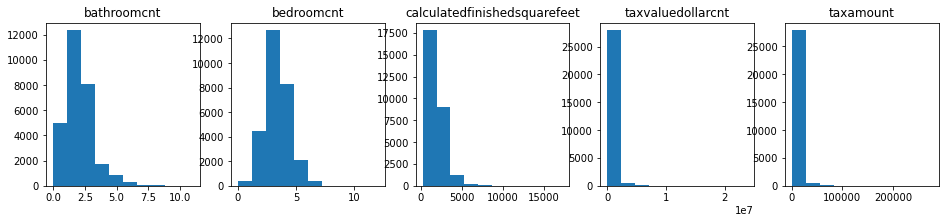

In [11]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,5, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=10)

    # Hide gridlines.
    plt.grid(False)


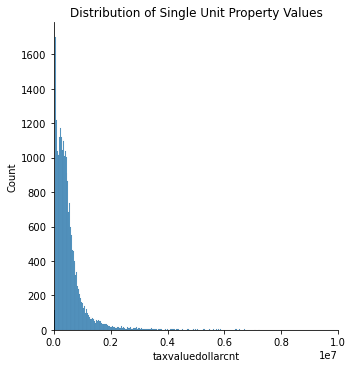

In [12]:
# Histogram of taxvaluedollarcnt
sns.displot(x='taxvaluedollarcnt', data=df)

plt.title('Distribution of Single Unit Property Values')
plt.xlim(0,10000000)
plt.show()

***
##### Visualization Notes
    * Data appears to be normally distributed
    * The fact that taxvaluedollarcnt & taxamount mirror each other is reassuring given shape of distributions
***

# Prepare

In [13]:
# Replace '-' with '' and Convert transactiondate to float
df['transactiondate'] = df['transactiondate'].str.replace("-", "")

In [14]:
# Convert to float
df['transactiondate'] = df['transactiondate'].astype(float)

In [15]:
# Convert float back to datetime format
df['transactiondate'] = pd.to_datetime(df['transactiondate'], format='%Y%m%d')

In [16]:
# Check changes
df.dtypes

parcelid                                 int64
bathroomcnt                            float64
bedroomcnt                             float64
calculatedfinishedsquarefeet           float64
fips                                   float64
yearbuilt                              float64
taxvaluedollarcnt                      float64
taxamount                              float64
propertylandusetypeid                  float64
transactiondate                 datetime64[ns]
dtype: object

In [17]:
# drop duplicated columns.  NO new information in duplicated entries
df = df.drop_duplicates(subset=['parcelid'])

In [18]:
# check shape to confirm 23 duplicates dropped
df.shape

(28382, 10)

In [19]:
# Check for nulls
df.isnull().any()

parcelid                        False
bathroomcnt                     False
bedroomcnt                      False
calculatedfinishedsquarefeet     True
fips                            False
yearbuilt                        True
taxvaluedollarcnt                True
taxamount                        True
propertylandusetypeid           False
transactiondate                 False
dtype: bool

In [20]:
# Count nulls
df.isnull().sum()

parcelid                         0
bathroomcnt                      0
bedroomcnt                       0
calculatedfinishedsquarefeet    58
fips                             0
yearbuilt                       81
taxvaluedollarcnt                1
taxamount                        1
propertylandusetypeid            0
transactiondate                  0
dtype: int64

In [21]:
# Drop nulls
df = df.dropna()

In [22]:
# check shape to confirm nulls dropped
df.shape

(28295, 10)

In [23]:
# rename columns
df = df.rename(columns={'bathroomcnt': 'baths', 'calculatedfinishedsquarefeet': 'sqft', 'bedroomcnt': 'beds', 'taxvaluedollarcnt':'value', 'taxamount':'taxes', 'propertylandusetypeid':'useid'})

In [24]:
# drop parcelid
df = df.drop(columns=('parcelid'))

In [25]:
# drop transactiondate
df= df.drop(columns=('transactiondate'))

In [26]:
df.dtypes

baths        float64
beds         float64
sqft         float64
fips         float64
yearbuilt    float64
value        float64
taxes        float64
useid        float64
dtype: object

In [27]:
#convert floats to ints to get rid of decimals
df = df.astype({'baths': 'int', 'beds': 'int', 'sqft':'int', 'yearbuilt':'int', 'value':'int', 'taxes':'int', 'useid':'int'})

In [28]:
df.dtypes

baths          int64
beds           int64
sqft           int64
fips         float64
yearbuilt      int64
value          int64
taxes          int64
useid          int64
dtype: object

***
##### Data Notes
    * calculatedfinishedsquarefeet contains 58 null/na values (0.2% of all observations)
    * yearbuilt contatins 81 nulls (0.3% of all observations)
    * taxamount  contains 1 null/na value (0.000% of all observations)
    * taxvaluedollarcnt contains 1 null/na value (0.000% of all observations)
    * Total nulls = 0.5% of all observations... Decision is to drop nulls
***

#### FIPS data manipulation

In [29]:
# convert fips to integer to drop decimals before converting to string
df['fips'] = df['fips'].astype(int)

In [30]:
# convert fips data to string so that we can split
df['fips'] = df['fips'].astype('str')

In [31]:
# confirm
df.dtypes

baths         int64
beds          int64
sqft          int64
fips         object
yearbuilt     int64
value         int64
taxes         int64
useid         int64
dtype: object

In [32]:
# Create State column by stripping state reference location(first two digits)
df['state'] = df['fips'].str[:1]

In [33]:
# Create County column by stripping state reference location(last three digits)
df['county'] = df['fips'].str[1:]

In [34]:
# check to see how many different states
df.state.value_counts()

6    28295
Name: state, dtype: int64

In [35]:
# check to see how many different counties
df.county.value_counts()

037    17915
059     7736
111     2644
Name: county, dtype: int64

In [36]:
# Replace numerics with labels
df['state'] = df['state'].replace("6", "California")
df['county'] = df['county'].replace({'037':'Los Angeles', '059':'Orange', '111':'Ventura'})

***
#### Notes on fips:
* fips codes in zillow data missing the leading zero for the state code first two digit assignment.  Only reason discovered this was by looking up standard fips codes are 5 digit...data only provides 
* first 2 numerics = state, last 3 numerics = county
* only 1 state code and 3 county codes in zillow dataframe

look up code references and construct new columns identifying state and counties (source: ahttps://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)
* State codes: 01 = CA
* County codes: 037=Los Angeles County, 059=Orange County & 111=Ventura County 
***

#### Calculate Tax Rate

In [37]:
df['tax_rate'] = round((df.taxes / df.value), 3)

In [38]:
df.tax_rate.describe()

count    28295.000000
mean         0.013301
std          0.007347
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.816000
Name: tax_rate, dtype: float64

In [39]:
df.tax_rate.sort_values(ascending=False).head(10)

21084    0.816
9910     0.453
1188     0.295
3569     0.278
8030     0.204
5664     0.183
8616     0.148
21629    0.143
1171     0.114
4163     0.111
Name: tax_rate, dtype: float64

In [40]:
# drop the rows with tax rates in excess of 0.3
df = df.drop(df[df['tax_rate']>0.3].index)

In [41]:
df.tax_rate.describe()

count    28293.000000
mean         0.013257
std          0.004937
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.295000
Name: tax_rate, dtype: float64

***
#### Notes on Tax Rate: Now that we have a calculated tax_rate should be easier to detect outliers
* no negative values 
* max didn't pass the smell test.  While some of the calculated tax rates seemed high, there were 2 in particular that stuck out at 45% & 81%. While other values did appear off, I decided to only cut these two as they were completely in a dimension of their own.
***

#### Split Data

In [42]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_zillow(df, 'value')

In [43]:
# validate split
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (15843, 11)
validate -> (6791, 11)
test -> (5659, 11)


#### Scale Data

In [44]:
import sklearn.preprocessing

# In order to scale features, it was necessary to scale one numpy array and then stack the unscaled array into one array
scaler = sklearn.preprocessing.RobustScaler()
X_train_scaled = np.column_stack((scaler.fit_transform(X_train[['baths', 'beds', 'sqft', 'taxes', 'tax_rate']]),X_train[['fips', 'yearbuilt', 'useid', 'state', 'county']]))
X_validate_scaled = np.column_stack((scaler.fit_transform(X_validate[['baths', 'beds', 'sqft', 'taxes', 'tax_rate']]),X_validate[['fips', 'yearbuilt', 'useid', 'state', 'county']]))
X_test_scaled = np.column_stack((scaler.fit_transform(X_test[['baths', 'beds', 'sqft', 'taxes', 'tax_rate']]),X_test[['fips', 'yearbuilt', 'useid', 'state', 'county']]))

In [45]:
# validate scaling operations(make sure shapes same as unscaled splits less the target feature)
print(f'X_train_scaled -> {X_train_scaled.shape}')
print(f'X_validate_scaled -> {X_validate_scaled.shape}')
print(f'X_test_scaled -> {X_test_scaled.shape}')

X_train_scaled -> (15843, 10)
X_validate_scaled -> (6791, 10)
X_test_scaled -> (5659, 10)


In [46]:
#convert numpy arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_validate_scaled_df = pd.DataFrame(X_validate_scaled)
X_test_scaled_df = pd.DataFrame(X_test_scaled)

In [47]:
# assign names back to columns in dataframe
X_train_scaled_df.columns=['baths', 'beds', 'sqft', 'taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid', 'state', 'county']
X_validate_scaled_df.columns=['baths', 'beds', 'sqft', 'taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid', 'state', 'county']
X_test_scaled_df.columns=['baths', 'beds', 'sqft', 'taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid', 'state', 'county']

# Data Exploration

In [48]:
# correlation matrix 
zillow_corr = train.drop(columns=['state']).corr()
zillow_corr

,baths,beds,sqft,yearbuilt,value,taxes,useid,tax_rate
baths,1.000000,0.638724,0.836378,0.466713,0.523452,0.526920,-0.046988,-0.094186
beds,0.638724,1.000000,0.632492,0.379027,0.292471,0.295324,-0.106195,-0.061153
sqft,0.836378,0.632492,1.000000,0.449938,0.619677,0.619718,-0.042012,-0.110290
yearbuilt,0.466713,0.379027,0.449938,1.000000,0.173613,0.177020,0.046294,-0.041061
value,0.523452,0.292471,0.619677,0.173613,1.000000,0.989616,-0.029347,-0.159020
taxes,0.526920,0.295324,0.619718,0.177020,0.989616,1.000000,-0.032996,-0.086382
useid,-0.046988,-0.106195,-0.042012,0.046294,-0.029347,-0.032996,1.000000,-0.030430
tax_rate,-0.094186,-0.061153,-0.110290,-0.041061,-0.159020,-0.086382,-0.030430,1.000000


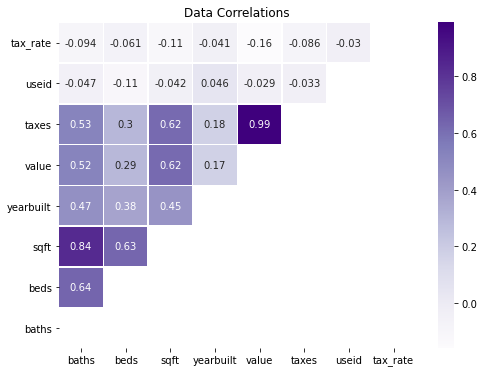

In [49]:
# correlation matrix (Heatmap)
plt.figure(figsize=(8,6))
sns.heatmap(zillow_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.ylim(0, 8)
plt.title('Data Correlations')
plt.show()

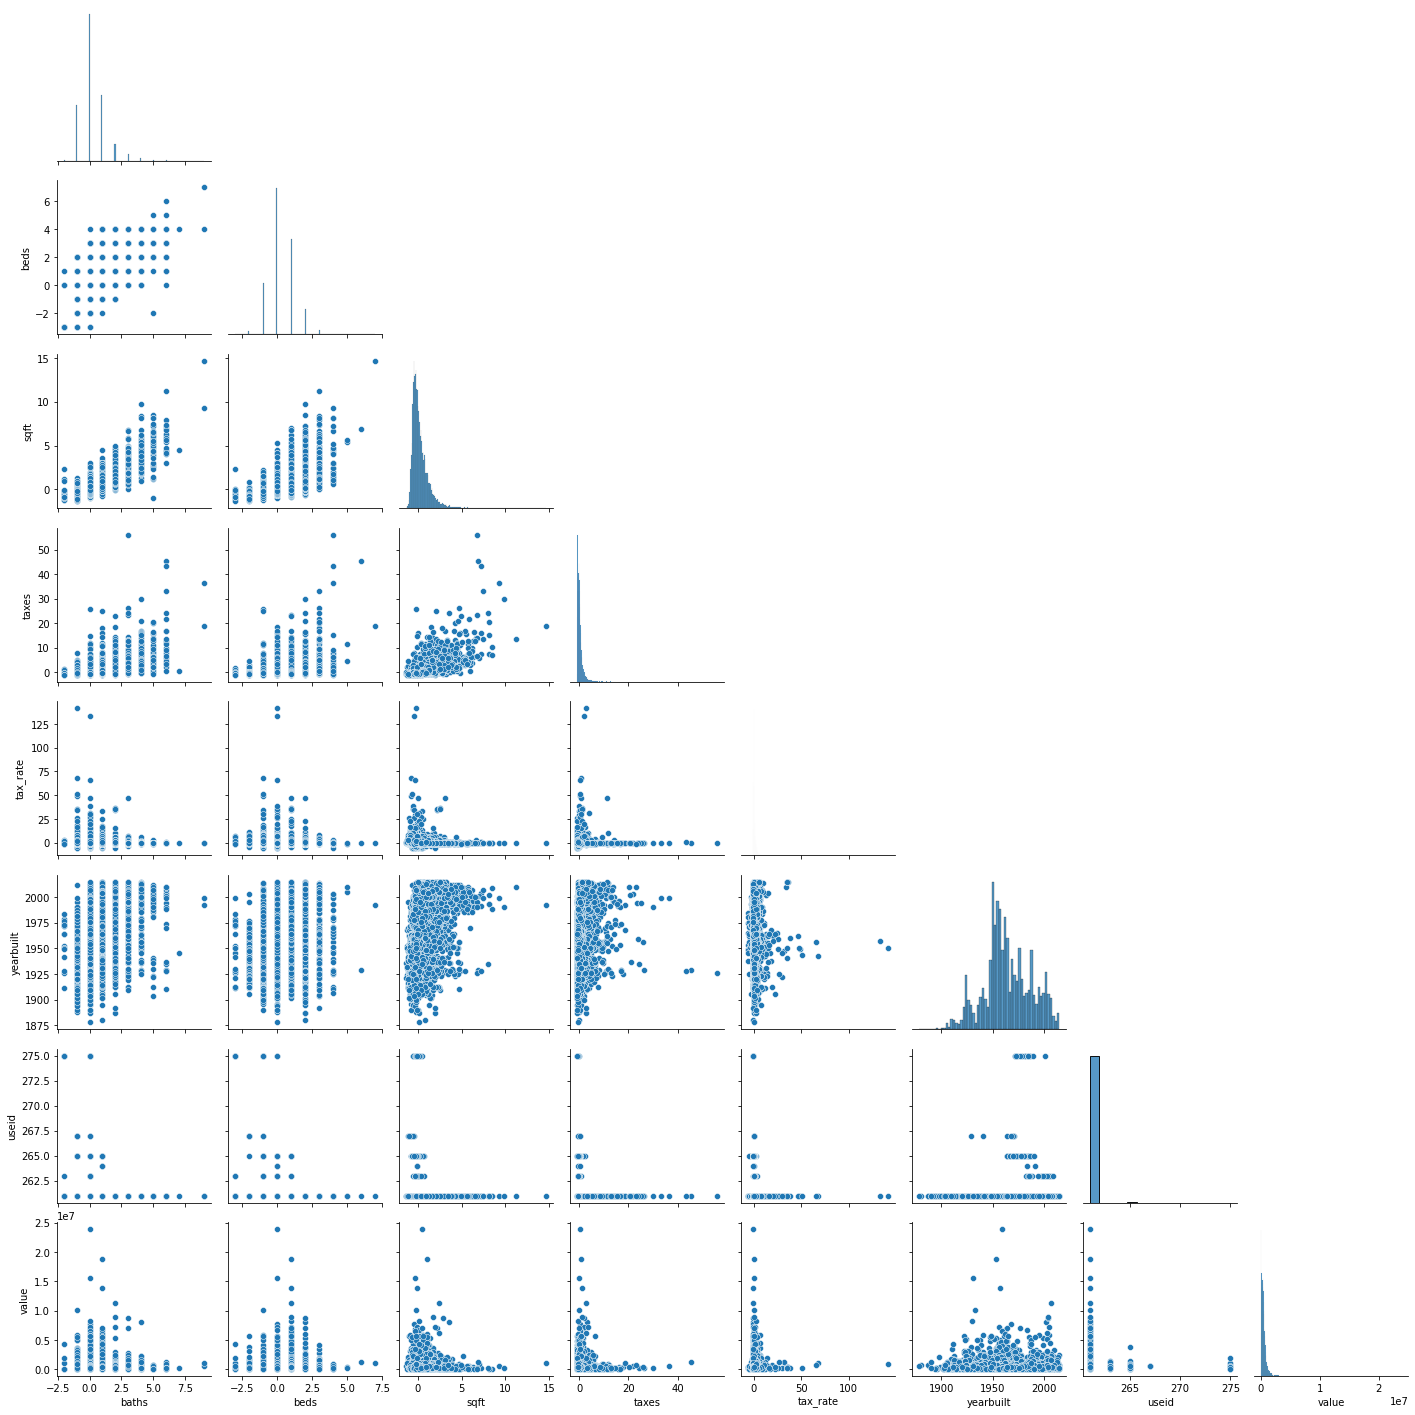

In [50]:
# add value back into scaled data and plot
y_train_df = pd.DataFrame(y_train)
X_pair = pd.concat([X_train_scaled_df, y_train_df], axis=1)

sns.pairplot(X_pair, corner=True)
plt.show()

Text(0.5, 1.0, 'Assessed Value by Square Feet')

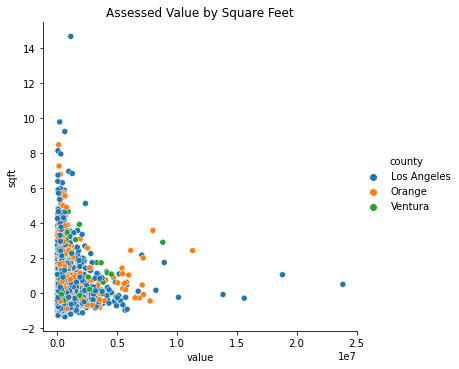

In [51]:
# Explore value by square foot
sns.relplot(data=X_pair, x='value', y='sqft', hue='county')
plt.title('Assessed Value by Square Feet')

Text(0.5, 1.0, 'Baths per Square Foot')

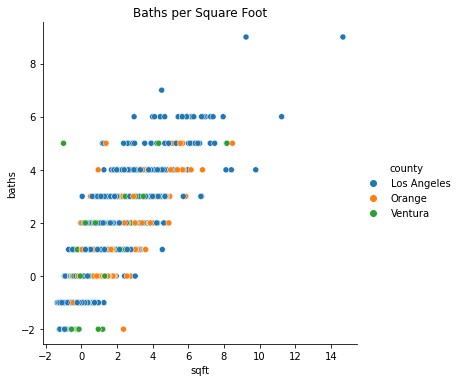

In [52]:
# Explore baths by square foot
sns.relplot(data=X_pair, x='sqft', y='baths', hue='county')
plt.title('Baths per Square Foot')

Text(0.5, 1.0, 'Bedrooms per Square Foot')

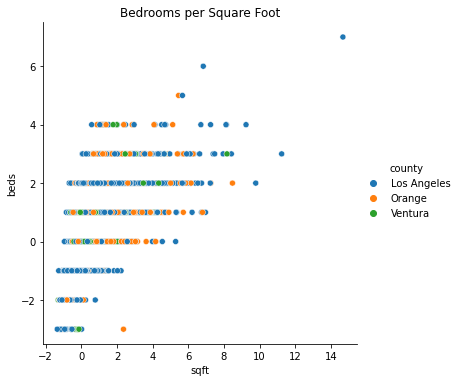

In [53]:
# explore beds by square foot
sns.relplot(data=X_pair, x='sqft', y='beds', hue='county')
plt.title('Bedrooms per Square Foot')

***
#### Data Exploration Taekaways:
* sqft, beds, and baths appear to be the strongest Single Unit Property Value drivers
* The data also suggests location ('county') could be a factor but the bulk of the observations grouped fairly consistently across locations with a relatively few outliers within Los Angeles county
* Both the beds & baths features appeared to correlate strongly with sqft which is to be expected
* Surprisingly, useid and yearbuilt did not appear to be strong drivers
* Interesting Note: Taxes and Tax_rates appear to group higher around yearbuilt=1950
    * suggesting something about Single Unit Properties built during this time is value "sticky"
***

# Hypothesis Testing

In [54]:
from math import sqrt
from scipy import stats

$H_0$: There is no correlation between sqft and value (independent)

$H_a$: The is some correlation between sqft and value (dependent)

alpha = 0.01

In [55]:
stats.ttest_ind(train.value, train.sqft)

Ttest_indResult(statistic=92.34394736223086, pvalue=0.0)

In [56]:
corr, p = stats.pearsonr(train.value, train.sqft)
corr, p

(0.6196773890515108, 0.0)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between sqft and value
</div>

$H_0$: There is no correlation between beds and value (independent)

$H_a$: The is some correlation between beds and value (dependent)

alpha = 0.01

In [57]:
stats.ttest_ind(train.value, train.beds)

Ttest_indResult(statistic=92.67785641396978, pvalue=0.0)

In [58]:
corr, p = stats.pearsonr(train.value, train.beds)
corr, p

(0.29247137307651183, 5.52897316064327e-310)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between beds and value
</div>

$H_0$: There is no correlation between baths and value (independent)

$H_a$: The is some correlation between baths and value (dependent)

alpha = 0.01

In [59]:
stats.ttest_ind(train.value, train.baths)

Ttest_indResult(statistic=92.67803767334853, pvalue=0.0)

In [60]:
corr, p = stats.pearsonr(train.value, train.baths)
corr, p

(0.5234519450525671, 0.0)

##### <div class="alert alert-block alert-success">We can reject the null hypothesis and confirm that there is a statistically significant correlation between baths and value
</div>

# Feature Engineering = SelectKBest

In [61]:
import sklearn.preprocessing

# Create new scaled df for this process droping state & county object types
scaler = sklearn.preprocessing.RobustScaler()
X_train_scaled2 = np.column_stack((scaler.fit_transform(X_train[['baths', 'beds', 'sqft', 'taxes', 'tax_rate']]),X_train[['fips', 'yearbuilt', 'useid']]))
X_validate_scaled2 = np.column_stack((scaler.fit_transform(X_validate[['baths', 'beds', 'sqft', 'taxes', 'tax_rate']]),X_validate[['fips', 'yearbuilt', 'useid']]))
X_test_scaled2 = np.column_stack((scaler.fit_transform(X_test[['baths', 'beds', 'sqft', 'taxes', 'tax_rate']]),X_test[['fips', 'yearbuilt', 'useid']]))

# Convert numpy array into a panda df
X_train_scaled2_df = pd.DataFrame(X_train_scaled2)
X_validate_scaled2_df = pd.DataFrame(X_validate_scaled2)
X_test_scaled2_df = pd.DataFrame(X_test_scaled2)


In [62]:
# Assign column labels to df
X_train_scaled2_df.columns=['baths', 'beds', 'sqft', 'taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid']
X_validate_scaled2_df.columns=['baths', 'beds', 'sqft', 'taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid']
X_test_scaled2_df.columns=['baths', 'beds', 'sqft', 'taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid']

In [63]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=2)

# find the top 2 X's correlated with y
f_selector.fit(X_train_scaled2_df, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled2_df.iloc[:,feature_mask].columns.tolist()

print(f_feature)

['sqft', 'taxes']


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 2)

# fit the data using RFE
rfe.fit(X_train_scaled2_df,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled2_df.iloc[:,feature_mask].columns.tolist()

print(rfe_feature)

['taxes', 'tax_rate']


***
#### SelectKBest Takeaways
* I decided to use SelectKBest because my feature pool is limited and a recursive selection process seemed like overapplication 
* As expected, My SelectKBest feature algo chose sqft and taxes as the most relevant drivers
    * During data exploratoration, I identified sqft as a main Single Unit Property Value driver.  The tax_rate is an obvious 'overfit' as it is a function of the target feature ('value).
    * What was surprising was the model didn't select either the baths of beds features.  I identified these as drivers during data exploration but the SelectKBest algorithm confirms a suspicion I had about correlation between these and sqft.  The algo results suggests that the relevance of the bed and baths is driven by their relation to sqft.
* As a control, I went ahead and ran the RFE algorithm and, as expected, the algo overfit in its feature selectiion identifying both features that are a function of the target feature ('value').
***

# Modeling

In [65]:
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

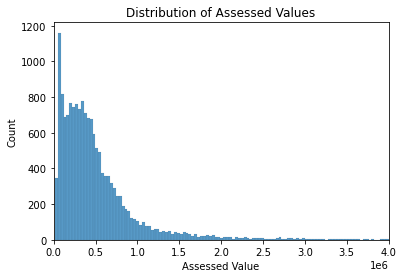

In [66]:
# Visualize target
ax= sns.histplot(y_train)
plt.xlim(0, 4000000)
plt.xlabel('Assessed Value')
plt.title('Distribution of Assessed Values')
plt.show()

#### The data appears to be normally distributed but with a left skew and long right tail 
* Assumption: Poisson or Tweedie best options

In [67]:
# Set Mean/Median benchmarks
y_train.mean(), y_train.median()

(538993.0773212144, 381637.0)

In [68]:
# Set y_train & y_validate as dataframes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [69]:
# Build Baselines into target dfs
y_train['value_mean'] = round(y_train['value'].mean())
y_validate['value_mean'] = round(y_train['value'].mean())
y_train['value_median'] = round(y_train['value'].median())
y_validate['value_median'] = round(y_train['value'].median())

In [70]:
#RMSE of value_mean
rmse_train = mean_squared_error(y_train.value, y_train.value_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.value, y_validate.value_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  731997.4 
Validate/Out-of-Sample:  639071.54


In [71]:
# RMSE of value_median
rmse_train2 = mean_squared_error(y_train.value, y_train.value_median)**(1/2)
rmse_validate2 = mean_squared_error(y_validate.value, y_validate.value_median)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train2, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate2, 2))

RMSE using Mean
Train/In-Sample:  748719.66 
Validate/Out-of-Sample:  654628.1


## Model dfs (Selected Features: beds, baths, sqft)

In [72]:
# Drop unwanted features from scaled dfs to create our model dataframes
X_train_scaled2_M = X_train_scaled2_df.drop(columns=(['taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid']))
X_validate_scaled2_M = X_validate_scaled2_df.drop(columns=(['taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid']))
X_test_scaled2_M = X_test_scaled2_df.drop(columns=(['taxes', 'tax_rate', 'fips', 'yearbuilt', 'useid']))

#### Linear Regression (OLS)

In [73]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model
lm.fit(X_train_scaled2_M, y_train.value)

# predict train
y_train['value_pred_lm'] = lm.predict(X_train_scaled2_M)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.value, y_train.value_pred_lm)**(1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate_scaled2_M)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.value, y_validate.value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm)

RMSE for OLS using LinearRegression
Training/In-Sample:  565849.8791664655 
Validation/Out-of-Sample:  510224.53505734936


#### LassoLars

In [74]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model  
lars.fit(X_train_scaled2_M, y_train.value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train_scaled2_M)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.value, y_train.value_pred_lars)**(1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate_scaled2_M)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.value, y_validate.value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  565849.9660158503 
Validation/Out-of-Sample:  510209.56075546175


#### Tweedie Regressor

In [75]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model
glm.fit(X_train_scaled2_M, y_train.value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train_scaled2_M)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.value, y_train.value_pred_glm)**(1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate_scaled2_M)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.value, y_validate.value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train_glm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  607209.3405587655 
Validation/Out-of-Sample:  530149.1667579837


#### Polynomial Regressor

In [76]:
# Create Polynomial Features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled2_M)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled2_M)
X_test_degree2 = pf.transform(X_test_scaled2_M)

In [77]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_lm2, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm2)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  541932.9778579157 
Validation/Out-of-Sample:  502357.2462187388


#### Evaluate

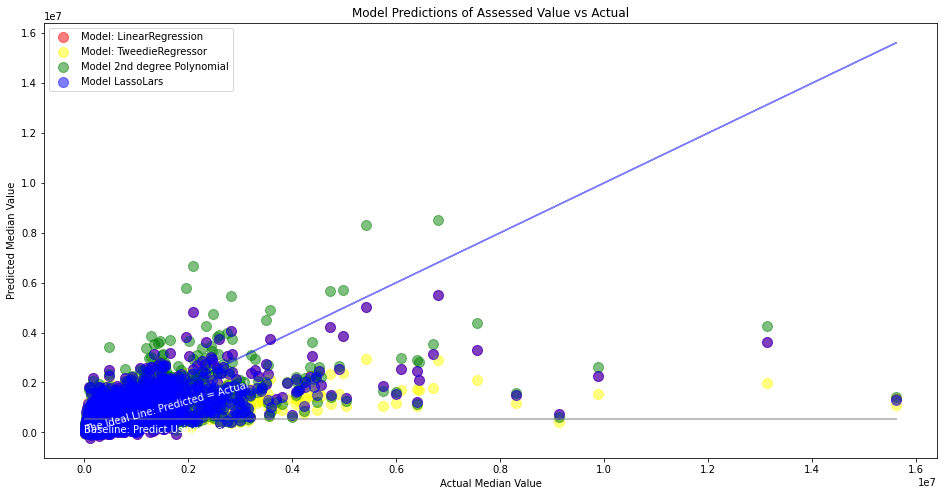

In [78]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.value, y_validate.value_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (20, 15), color ="white")
plt.plot(y_validate.value, y_validate.value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.01, .01), color="white", rotation=15.5)

plt.scatter(y_validate.value, y_validate.value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.value, y_validate.value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.value, y_validate.value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.value, y_validate.value_pred_lars, 
            alpha=.5, color="blue", s=100, label="Model LassoLars")
plt.legend()
plt.xlabel("Actual Median Value")
plt.ylabel("Predicted Median Value")
plt.title("Model Predictions of Assessed Value vs Actual")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

#### Residual Plots: Plotting the Errors in Predictions

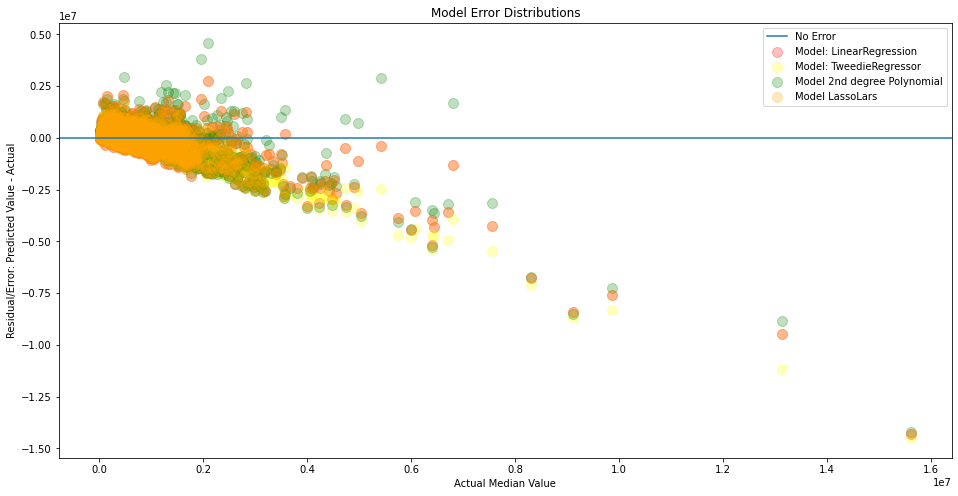

In [79]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.value, y_validate.value_pred_lm - y_validate.value, 
            alpha=.25, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.value, y_validate.value_pred_glm - y_validate.value, 
            alpha=.25, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.value, y_validate.value_pred_lm2-y_validate.value, 
            alpha=.25, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.value, y_validate.value_pred_lars-y_validate.value, 
            alpha=.25, color="orange", s=100, label="Model LassoLars")
plt.legend()
plt.xlabel("Actual Median Value")
plt.ylabel("Residual/Error: Predicted Value - Actual")
plt.title("Model Error Distributions")
plt.annotate("", (2.0, -10))
plt.annotate("", (15.5, 3))
plt.show()

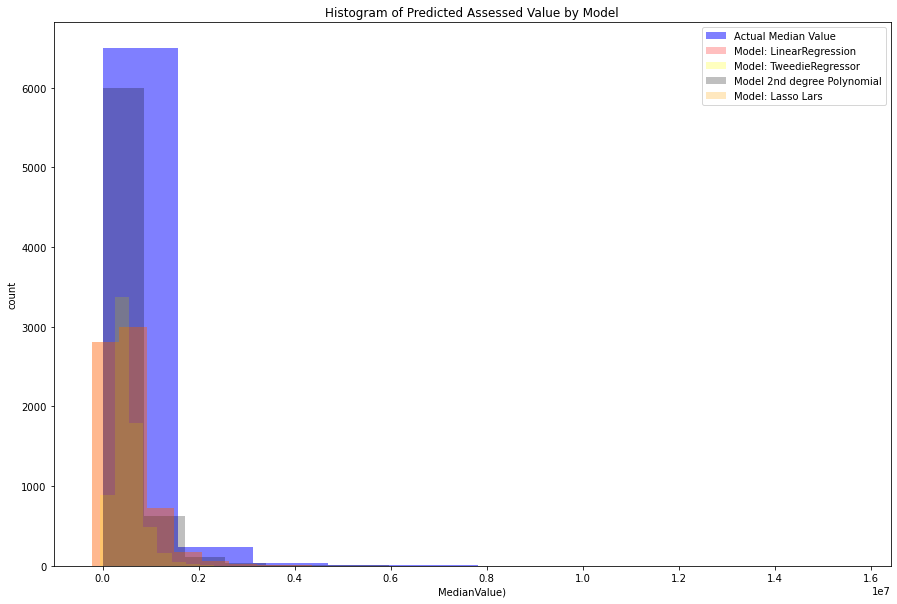

In [80]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(15,10))
plt.hist(y_validate.value, color='blue', alpha=.5, label="Actual Median Value")
plt.hist(y_validate.value_pred_lm, color='red', alpha=.25, label="Model: LinearRegression")
plt.hist(y_validate.value_pred_glm, color='yellow', alpha=.25, label="Model: TweedieRegressor")
plt.hist(y_validate.value_pred_lm2, color='black', alpha=.25, label="Model 2nd degree Polynomial")
plt.hist(y_validate.value_pred_lars, color='orange', alpha=.25, label="Model: Lasso Lars")
plt.xlabel("MedianValue)")
plt.ylabel("count")
plt.title("Histogram of Predicted Assessed Value by Model")
plt.legend()
plt.show()

***
#### Model Selection
* All models beat the benchmarks and were mostly in line with each other with the exception of the Polynomial Regressor
* The Polynomial Regressor largely underpeformed the Tweedie Regressor in the dense MedianValue<250k observation sample but outperformed as MedianValues rose.  
    * Competing model errors continually grew as MedianValues rose vs Polynomial Regresssor
* I decided not to treat the MedianValue tail not as an outlier due to the number, frequency and consistentcy of these observations.  Although the observations were limited compared to the bulk of the data, I believe there are additional features to be explored that may have some explantory value that my Polynomail Regressor model was picking up on better than the others.
    * Interesting observation: in the exploratory data, tax_rate and taxes appeared to group higher in older homes.  Perhaps there is a premium for established locations or historical districts.   I did not evaluate location vs value but would recommend that in Next Steps.
    
Selected Model to test: Polynomial Regressor
***




y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.value, y_test.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nOut-of-Sample Performance: ", rmse_test)

# Deliverables

#### Histogram of tax_rates by County

Text(0.5, 1.0, 'Tax Rates by County (%)')

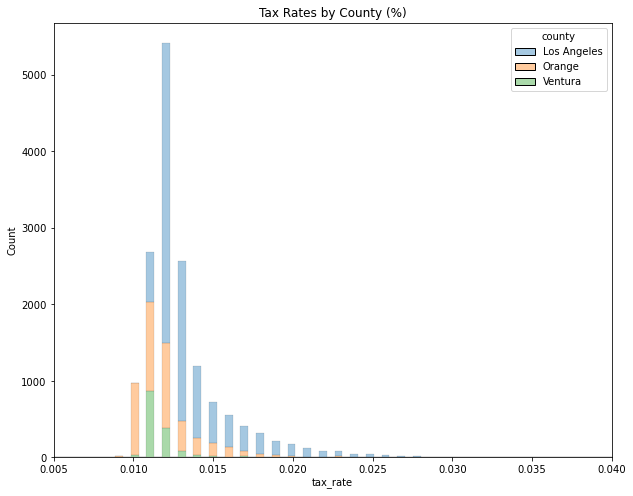

In [81]:
plt.figure(figsize=(10,8))
sns.histplot(data=train, x="tax_rate", hue="county", bins = 600, multiple='stack', alpha=0.4)
plt.xlim(0.005, 0.04)
plt.title("Tax Rates by County (%)")